In [2]:
#!/usr/bin/env python
# coding: utf-8
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import itertools
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
# from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")
#如果没有这个目录，则创建这个目录
if not os.path.isdir('result'):
    os.mkdir('result')

In [3]:
df = pd.read_csv("NVDA.csv") 
df.head()

,Date,Close
0,1999/1/22,0.410156
1,1999/1/25,0.453125
2,1999/1/26,0.417969
3,1999/1/27,0.416667
4,1999/1/28,0.415365


In [5]:
data=df['Close']
date=df['Date'] 

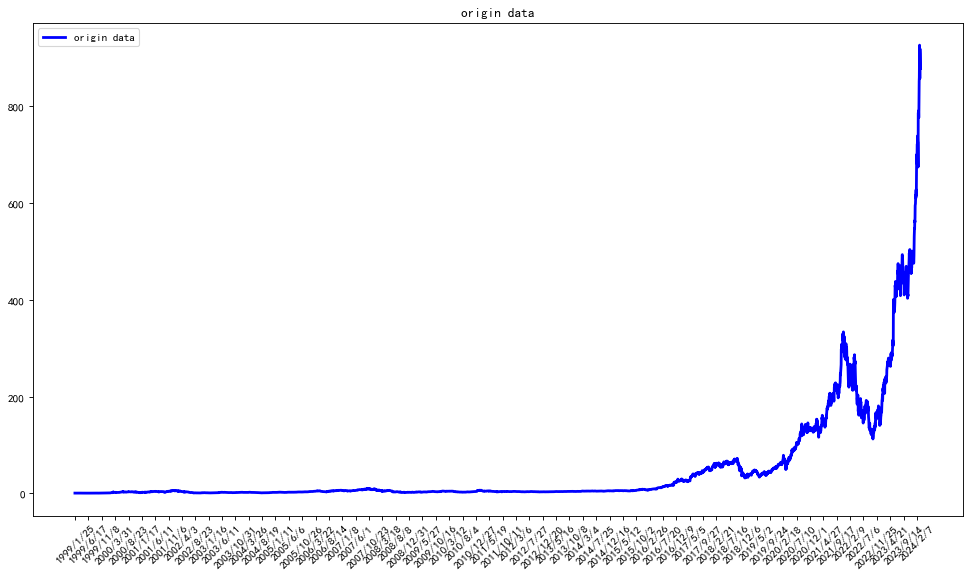

In [7]:
#显示原数据
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date, data, label="origin data", color='b',lw=2.5)  #若不需要日期或者数据没有日期可改成plt.plot(data, label=" ", color='b',lw=2.5)
plt.title("origin data")
plt.xticks(range(1,len(data),100),rotation=45)
plt.legend()
plt.savefig('result/origin_data.png')
plt.show()

In [8]:
#定义稳定性检验函数
def adf_val(ts, ts_title):
    '''
    ts: 时间序列数据，Series类型
    ts_title: 时间序列图的标题名称，字符串
    '''
    # 稳定性（ADF）检验
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)
    name = ['adf', 'pvalue', 'usedlag','nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,critical_values, icbest]
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,
    # 返回adf值、adf的p值、三种状态的检验值

In [9]:
def acorr_val(ts):
    '''
    # 白噪声（随机性）检验
    ts: 时间序列数据，Series类型
    返回白噪声检验的P值
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1) 
    return lbvalue, pvalue


def tsplot(y, lags=None, figsize=(15, 8)):
    fig = figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title('origin data')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()

    fig.tight_layout()
    fig.savefig('result/ACF_PACF.png')
    fig.show()

    return ts_ax, acf_ax, pacf_ax

In [10]:
ts_data = data.astype('float32')

In [11]:
#平稳性检验
adf, pvalue, critical_values = adf_val(ts_data, 'raw time series') 
print('adf',adf)
print('pvalue',pvalue)
print('critical_values',critical_values)
#结果显示，adf结果为5.148779039915342..， 不小于critical_values的三个level的统计值。pvalue也不接近于0 的，所以是不平稳的，所以需要做一阶差分
#若p值远小于0.01，认为该时间序列是平稳的
#白噪声检验
aco=acorr_val(ts_data)
print('aco',aco)

[('adf', 5.148779039915342), ('pvalue', 1.0), ('usedlag', 34), ('nobs', 6293), ('critical_values', {'1%': -3.4313895629133992, '5%': -2.8619993951727514, '10%': -2.567014533031778}), ('icbest', 33827.89381545007)]
adf 5.148779039915342
pvalue 1.0
critical_values {'1%': -3.4313895629133992, '5%': -2.8619993951727514, '10%': -2.567014533031778}
aco ('lb_stat', 'lb_pvalue')


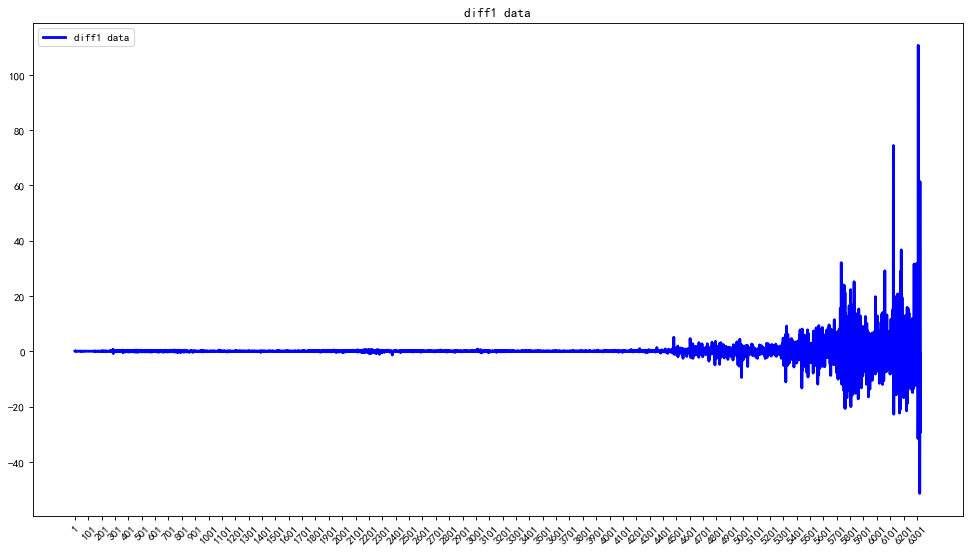

In [15]:
#若数据检验不平稳，则可以通过差分的方式使数据趋于平稳
diff1 = ts_data.diff(1)#一阶差分

#显示一阶差分结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(diff1, label="diff1 data", color='b',lw=2.5)
plt.title("diff1 data")
plt.xticks(range(1,len(data),100),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/diff1.png')
plt.show()

In [16]:
#检验一阶差分是否已经平稳
adf1, pvalue1, critical_values1 = adf_val(diff1.dropna(), 'raw time series')
print('adf1',adf1)
print('pvalue1',pvalue1)
print('critical_values1',critical_values1)
#检验一阶差分的白噪声
aco1=acorr_val(diff1.dropna())
print('aco1',aco1)
#若一阶差分仍不平稳，可以进行二阶差分
#此案例中一阶差分已经平稳，所以在后面的寻参中d=1

[('adf', -5.764167976568144), ('pvalue', 5.582534766142472e-07), ('usedlag', 32), ('nobs', 6294), ('critical_values', {'1%': -3.431389397678675, '5%': -2.861999322166334, '10%': -2.567014494168742}), ('icbest', 33848.01891022432)]
adf1 -5.764167976568144
pvalue1 5.582534766142472e-07
critical_values1 {'1%': -3.431389397678675, '5%': -2.861999322166334, '10%': -2.567014494168742}
aco1 ('lb_stat', 'lb_pvalue')


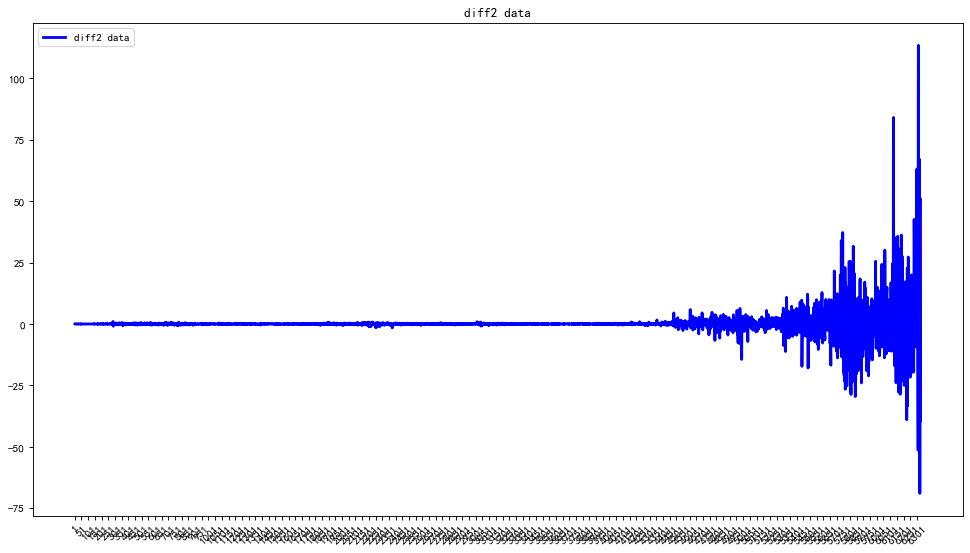

In [17]:
#在一阶差分的基础上进行二阶差分,若一阶差分不平稳可以作二阶差分，这里按需自取
diff2 = ts_data.diff(2)

#显示二阶差分的结果
fig = plt.figure(figsize=(15, 8), dpi=80)
plt.plot(diff2, label="diff2 data", color='b',lw=2.5)
plt.title("diff2 data")
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/diff2.png')
plt.show()

(<Axes: title={'center': 'origin data'}>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

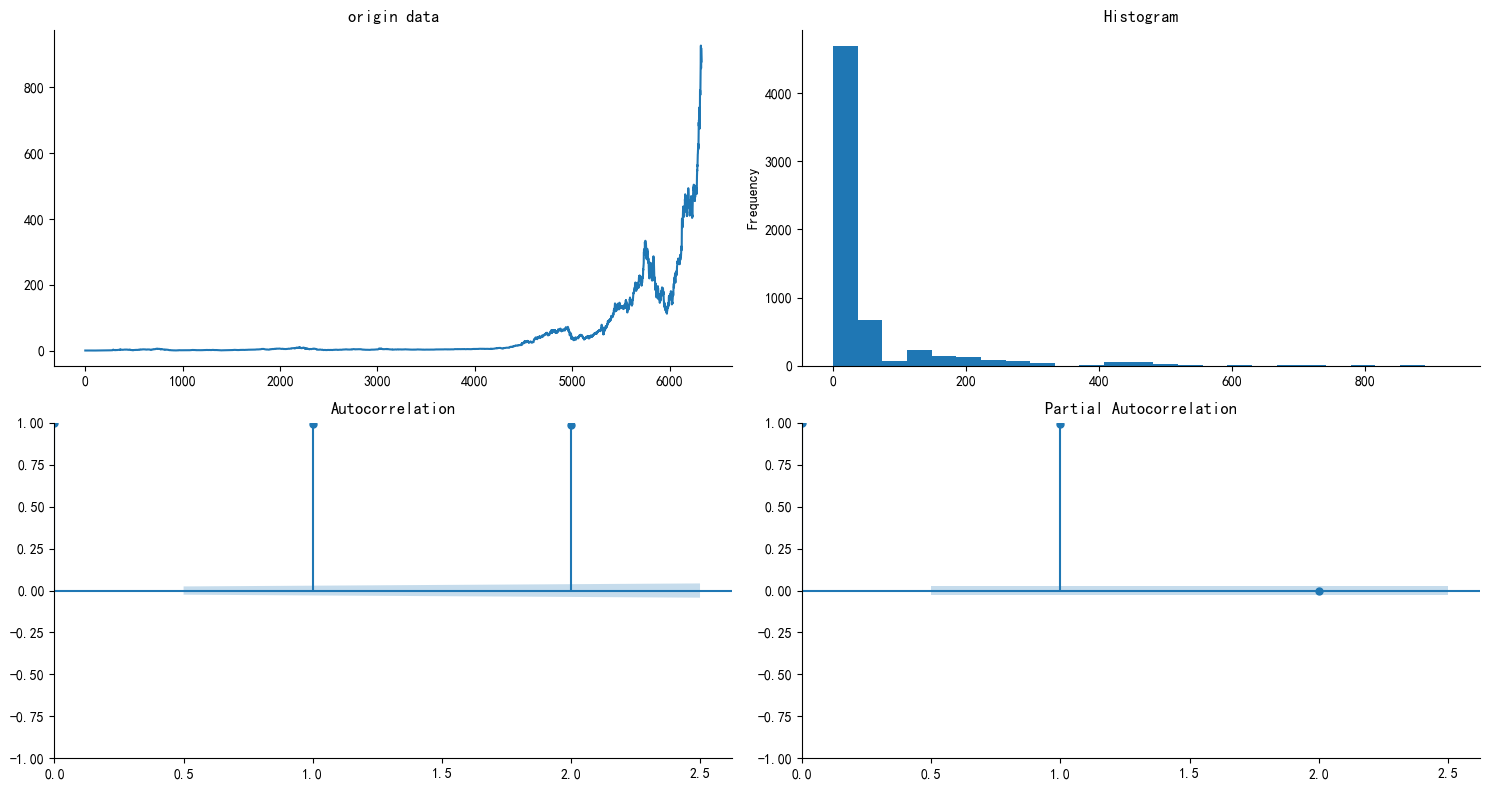

In [18]:
##显示原数据（未差分）的自相关ACF和偏自相关PACF
tsplot(ts_data, lags=2)

In [19]:
#确定ARIMA的p、q、d参数，
#一种方式可以根据上述的ACF图和PACF图来确定
#另一种方式可以用个AIC或者BIC指标进行选取参数，这里用AIC进行确定，采用网格搜索进行寻参
# #AIC和BIC计算最好的pdq值
q_arima = range(0, 3)#定义q值的范围
d_arima = 1 #d值为差分项，若原数据平稳不需要进行差分则d=0,否则d为原始数据差分稳定的阶数
p_arima = range(0, 3)#定义p值的范围
AIC_arima = [] #定义AIC列表存储AIC值
ARIMAX_model = []#定义模型参数列表存储参数值
#循环各组参数
pdqs = [(x[0], d_arima, x[1]) for x in list(itertools.product(p_arima, q_arima))]
import statsmodels.api as sm
#原来的源码是22年的，现在statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA已经被弃用，所以重新导入
#另：disp参数也被移除了
for pdq in pdqs:
        results = sm.tsa.ARIMA(data, order=pdq).fit()
        print('ARIMA{} - AIC:{}'.format(pdq, results.aic))
        AIC_arima.append(results.aic)
        ARIMAX_model.append(pdq)


print('AIC_arima')
print(AIC_arima)
index=AIC_arima.index(min(AIC_arima))
order = ARIMAX_model[index] #获取最好的p，q,d参数值 （有些数据可能获取p,q,d参数会出现错误,这个还不知道为什么)
print('order num',order)

ARIMA(0, 1, 0) - AIC:34574.972164880455
ARIMA(0, 1, 1) - AIC:34576.927368398385
ARIMA(0, 1, 2) - AIC:34532.69449529595
ARIMA(1, 1, 0) - AIC:34576.93502209528
ARIMA(1, 1, 1) - AIC:34538.83538560814
ARIMA(1, 1, 2) - AIC:34508.637226558494
ARIMA(2, 1, 0) - AIC:34532.08937406694
ARIMA(2, 1, 1) - AIC:34509.74902229906
ARIMA(2, 1, 2) - AIC:34510.528135054745
AIC_arima
[34574.972164880455, 34576.927368398385, 34532.69449529595, 34576.93502209528, 34538.83538560814, 34508.637226558494, 34532.08937406694, 34509.74902229906, 34510.528135054745]
order num (1, 1, 2)


In [20]:
# 根据AIC寻参的结果定义ARIMA参数为（1,1,2）
order=(1,1,2)#有时候寻参出来的参数也不一定能用，可能需要调一下（出错情况下）

#  构建训练数据
ndata=np.array(data).reshape(-1,1)
#划分训练集和测试集
train_len=int(len(ndata)*0.8)#取80%数据作为训练集
train_ar = ndata[:train_len,:]#取数据[行或行区间(:),列或列区间(:)]
test_ar = ndata[train_len:,:]

history = [x for x in train_ar]
print(type(history))
pre = list()
from tqdm import tqdm
#训练ARIMA模型
for t in tqdm(range(len(test_ar))):
    model = sm.tsa.ARIMA(history, order=order)
    model_fit = model.fit()#模型训练
    output = model_fit.forecast()#模型预测
    yhat = output[0]
    pre.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
#数据类型转换
pre=np.array(pre)

<class 'list'>


100%|██████████████████████████████████████████████████████████████████████████████| 1266/1266 [26:18<00:00,  1.25s/it]


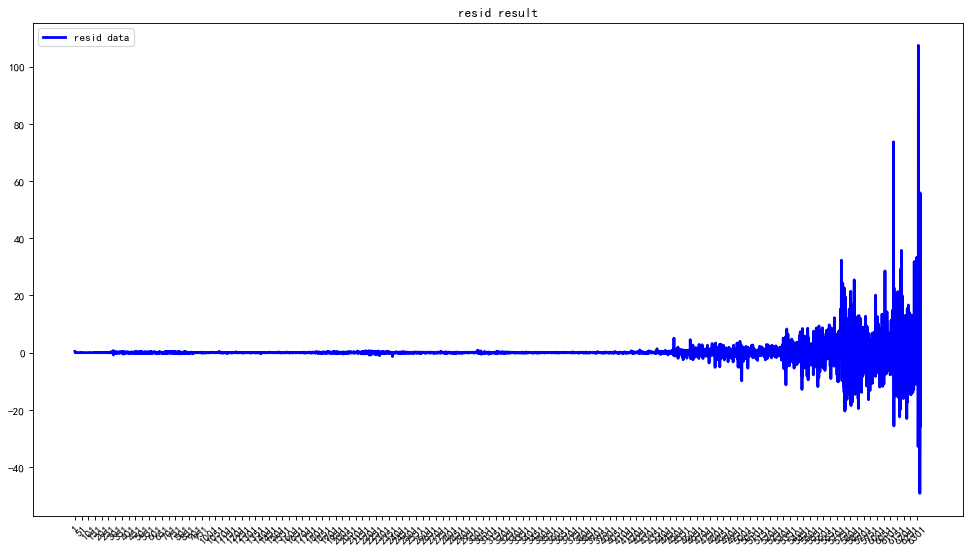

In [21]:
resid=model_fit.resid  #残差
#显示残差校验
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(resid, label="resid data", color='b',lw=2.5)
plt.title("resid result")
plt.xticks(range(1,len(data),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/resid_result.png')
plt.show()

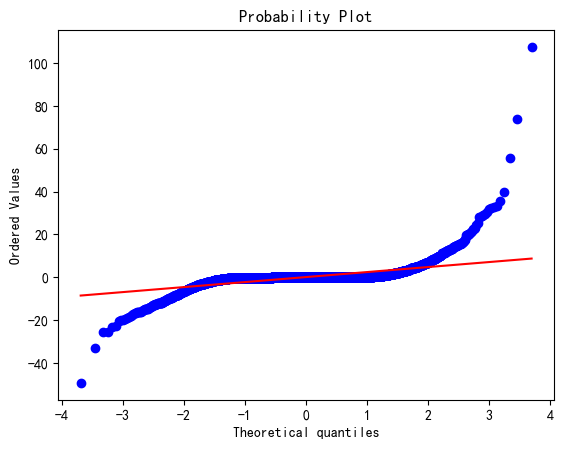

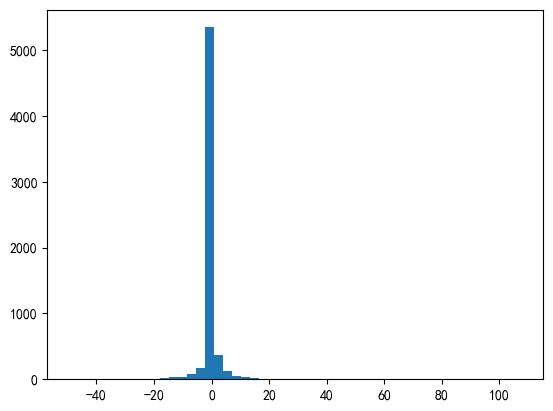

In [22]:
stats.normaltest(resid)#检验序列残差是否为正态分布
#qq图散点基本在直线上，同时直方图也呈现正态性
stats.probplot(resid, dist="norm", plot=plt)
plt.show()
plt.hist(resid,bins=50)
plt.show()

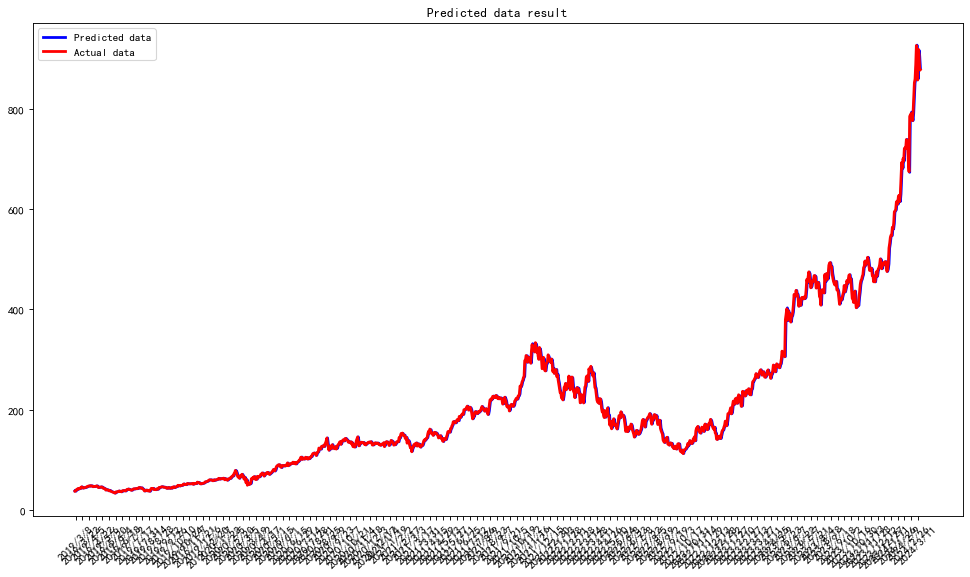

In [23]:
#显示预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(date[train_len:],pre, label="Predicted data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(date[train_len:],test_ar, label="Actual data", color='r',lw=2.5)
plt.title("Predicted data result")
plt.xticks(range(1,len(pre),10),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/predict_result.png')
plt.show()


In [24]:
#保存Arima预测结果到本地
result=np.concatenate((pre.reshape(-1,1),test_ar),axis=1)
dg=pd.DataFrame(result,columns=['predict','true'])
dg.to_csv('result/result.csv')

In [25]:
#根据arima模型预测的值构建新的数据训练lstm
arima_result = pd.DataFrame(columns=['close'])#生成一个新的DataFrame空数据
arima_result['close'] = test_ar.ravel()#把ARIMA测试数据赋值给新的DataFrame空数据
arima_result['predicted'] = pre.ravel()#把ARIMA预测数据赋值给新的DataFrame空数据
arima_result['residuals'] = arima_result['close'] - arima_result['predicted']#获取这两数据的残缺

#以下是lstm部分
lstm_data=arima_result['residuals'].values#获取残缺项并做数据类型转换
#声明归一化变量
sc = MinMaxScaler(feature_range=(0, 1))
#反归一化
sc_data = sc.fit_transform(lstm_data.reshape(-1,1))


In [26]:
seq_len = 2  #时间步长 t-2,t-1 --->t
#转换成网络模型所需格式，（样本数，步长，特征数）
X_train = np.array([sc_data[i : i + seq_len, :] for i in range(sc_data.shape[0] - seq_len)])
y_train = np.array([sc_data[i + seq_len, :] for i in range(sc_data.shape[0]- seq_len)])

print(X_train.shape,y_train.shape)

(1264, 2, 1) (1264, 1)


In [27]:
#lstm网络,keras
model = Sequential()
#lstm层，神经元数为128，input_shape=(X_train.shape[1], X_train.shape[2])为网络输入数据形状声明
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))#lstm层，神经元数为128
# model.add(LSTM(units=128,activation='tanh',return_sequences=False))#lstm层，神经元数为128
model.add(Dropout(0.2))#dropout层
model.add(Dense(1))#全连接层
model.compile(loss='mean_squared_error', optimizer='adam')
#训练，训练次数为100，batch_size批次大小为32
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)


Epoch 1/100
40/40 - 3s - 77ms/step - loss: 0.0273
Epoch 2/100
40/40 - 0s - 4ms/step - loss: 0.0038
Epoch 3/100
40/40 - 0s - 5ms/step - loss: 0.0035
Epoch 4/100
40/40 - 0s - 4ms/step - loss: 0.0034
Epoch 5/100
40/40 - 0s - 8ms/step - loss: 0.0034
Epoch 6/100
40/40 - 0s - 4ms/step - loss: 0.0034
Epoch 7/100
40/40 - 0s - 4ms/step - loss: 0.0032
Epoch 8/100
40/40 - 0s - 5ms/step - loss: 0.0032
Epoch 9/100
40/40 - 0s - 9ms/step - loss: 0.0033
Epoch 10/100
40/40 - 0s - 5ms/step - loss: 0.0031
Epoch 11/100
40/40 - 0s - 5ms/step - loss: 0.0032
Epoch 12/100
40/40 - 0s - 4ms/step - loss: 0.0031
Epoch 13/100
40/40 - 0s - 5ms/step - loss: 0.0031
Epoch 14/100
40/40 - 0s - 8ms/step - loss: 0.0030
Epoch 15/100
40/40 - 0s - 5ms/step - loss: 0.0031
Epoch 16/100
40/40 - 0s - 4ms/step - loss: 0.0031
Epoch 17/100
40/40 - 0s - 3ms/step - loss: 0.0031
Epoch 18/100
40/40 - 0s - 3ms/step - loss: 0.0030
Epoch 19/100
40/40 - 0s - 4ms/step - loss: 0.0029
Epoch 20/100
40/40 - 0s - 3ms/step - loss: 0.0029
Epoch 21

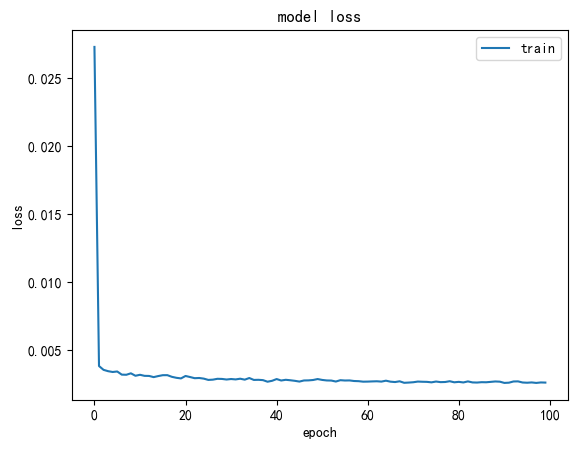

In [28]:
# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
# 预测训练集数据，预测数据为残缺项数据
lstm_pred = model.predict(X_train)
#对lstm_pred进行反归一化
lstm_pred = sc.inverse_transform(lstm_pred)#反归一化数据为为残缺项数据的预测数据
#对y_train进行反归一化
ytrue = sc.inverse_transform(y_train.reshape(-1,1))#反归一化数据为残缺项数据的真实值


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [30]:
#dtest为最终得到整个arima-lstm模型的预测结果，ytrue为真实值
arima_resid=arima_result['predicted'][-len(lstm_pred):].values.astype(float).reshape(-1,1)
dtest=arima_resid+lstm_pred
ytrue=arima_result['close'][-len(ytrue):].values.reshape(-1,1)+ytrue
#保存Arima-LSTM预测结果到本地
new_result=np.concatenate((dtest,ytrue),axis=1)
dg=pd.DataFrame(new_result,columns=['predict','true'])
dg.to_csv('result/arima_lstm_result.csv')

In [31]:
#计算评价指标
mse = mean_squared_error(ytrue, dtest)
mae = mean_absolute_error(ytrue, dtest)
rmse = np.sqrt(mse)
r2 = r2_score(ytrue,dtest)
# 保存评价指标数据
df_eval = pd.DataFrame([[mae, rmse, mse, r2]], columns=['mae', 'rmse', 'mse', 'r2'])
df_eval.to_csv('result/eval.csv')
print('mse: %.3f' % mse)
print('mae: %.3f' % mae)
print('rmse: %.3f' % rmse)
print('r2: %.3f' % r2)

mse: 272.552
mae: 9.602
rmse: 16.509
r2: 0.990


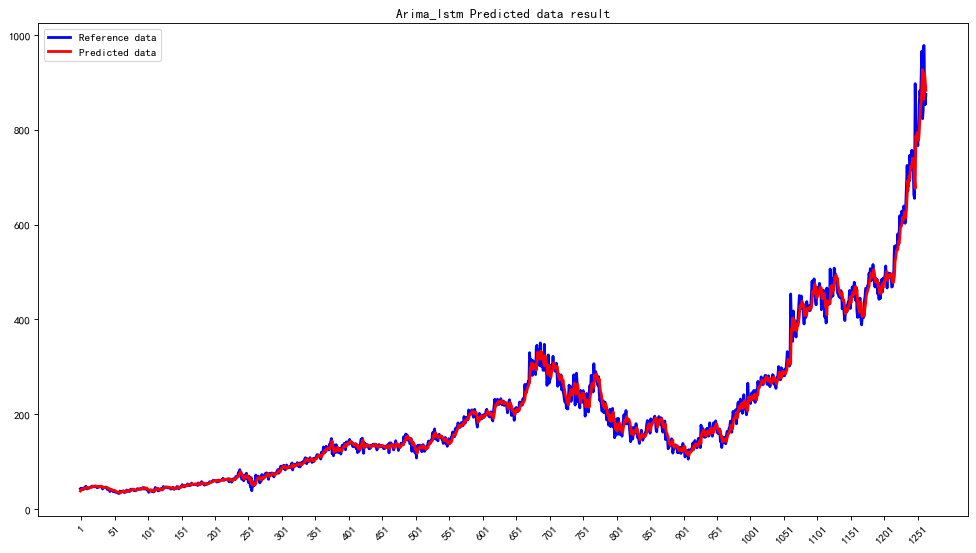

In [32]:
#显示ARIMA-LSTM预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ytrue, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.xticks(range(1,len(pre),50),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/arima_lstm_predict_result1.png')
plt.show()

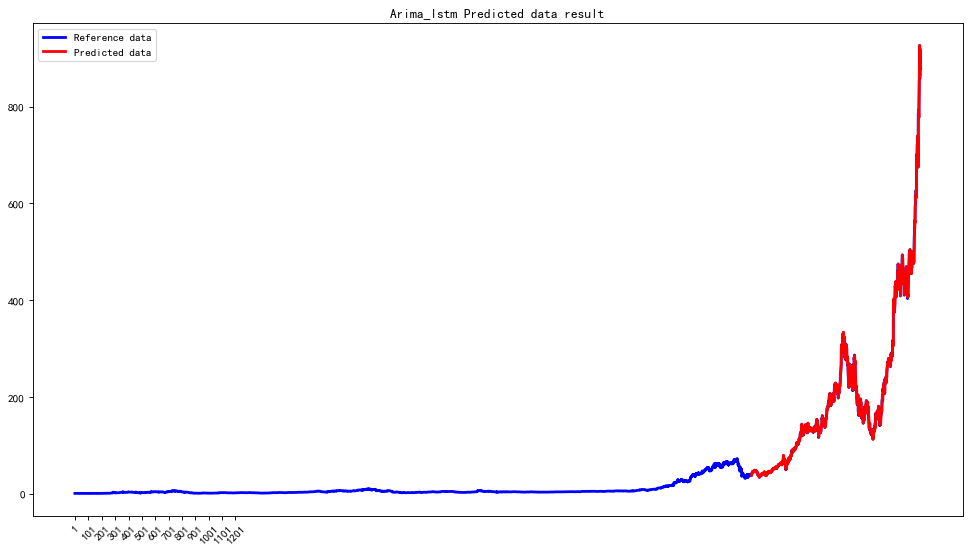

In [34]:
##显示前段数据段加上ARIMA-LSTM预测结果
fig = figure(figsize=(15, 8), dpi=80)
plt.plot(ndata, label="Reference data", color='b',lw=2.5) #若不需要日期或者数据没有日期可改成plt.plot(pre, label="Predicted data", color='b',lw=2.5)
plt.plot(range(train_len+seq_len,len(ndata)),dtest, label="Predicted data", color='r',lw=2.5)
plt.title("Arima_lstm Predicted data result")
plt.xticks(range(1,len(pre),100),rotation=45) #为了横坐标显示清楚，通过间隔50个显示一个值
plt.legend()
plt.savefig('result/arima_lstm_predict_result2.png')
plt.show()